# Generating Unique Architectures using GANs

**Generative Adversarial Networks (GANs)** are a class of deep neural networks consisting of two neural networks competing against each other. We have the generator and discriminator.
In this tutorial, we will be generating unique architectures using GANs. 

### Importing the libraries

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import helper
from glob import glob
import pickle as pkl
import scipy.misc
import time
import tensorflow as tf # make sure tensorflow version is 1.x.x

# if you have tensorflow 2.0, uncomment these 2 lines to use tensorflow v1 
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

### Data
- We are using the [wikiarts](https://www.wikiart.org/en/paintings-by-genre/abstract?select=featured#!#filterName:featured,viewType:masonry) data. Download the dataset [here](https://drive.google.com/file/d/1ciCghKm-N8bXpiJ1qqlYBvmms_rlmKb0/view).
- Change `do_preprocess = True` to resize the images.

In [3]:
preprocess = False # change if converting image size
from_checkpoint = False # change if training from saved model

### Resize images to 128x128

In [4]:
data_dir = './data/' # Data
resized_data_dir = "./resized_data" # Directory to save Resized data

if preprocess == True:
    # Create resized folder if not exist
    if not os.path.exists(resized_data_dir):
        os.mkdir(resized_data_dir)

    for each in os.listdir(data_dir):
        # Read the image
        image = cv2.imread(os.path.join(data_dir, each))
        image = cv2.resize(image, (128, 128))
        # Save the resized image
        cv2.imwrite(os.path.join(resized_data_dir, each), image)

### Explore the data

Let us display our image samples.

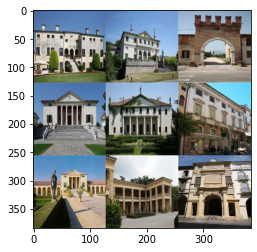

In [5]:
show_imgs = 15
data_imgs = helper.get_batch(glob(os.path.join(resized_data_dir, '*.jpg'))[:show_imgs], 64, 64, 'RGB')
plt.imshow(helper.images_square_grid(data_imgs, 'RGB'))

## DCGAN Architecture

### 1. Input to the network

Creating TensorFow placeholders for the inputs to the network.

- Real input images placeholder `real_dim`.
- Z input placeholder `z_dim`, i.e., the noise vector.
- Learning rate placeholder for generator.
- Learning rate placeholder for discriminator.
<br>

In [6]:
def gan_model_inputs(real_dim, z_dim):
    """
    Creates the inputs for the model.
    
    Arguments:
    ----------
    :param real_dim: tuple containing width, height and channels
    :param z_dim: The dimension of Z
    ----------
    Returns:
    Tuple of (tensor of real input images, tensor of z (noise) data, Generator learning rate, Discriminator learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, (None, *real_dim), name='real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name="z_inputs")
    generator_learning_rate = tf.placeholder(tf.float32, name="generator_learning_rate")
    discriminator_learning_rate = tf.placeholder(tf.float32, name="discriminator_learning_rate")
    
    return real_inputs, z_inputs, generator_learning_rate, discriminator_learning_rate


### 2. The Generator Network

- The DCGAN Generator uses a de-convolutional neural network architecture that takes in the random noise vector (z) as the input, passes it through several layers of batch normalization and Leaky ReLu with filter size halved at every layer. 
- The Leaky ReLu activation is used to avoid gradient vanishing and is used in all layers except the last layer. 
- The final output is generated through a tanh activation function in the last layer, which results a 128x128x3 size image.

<img src="./imgs/generatorarch.png">

In [7]:
def build_generator(z, output_channel_dim, is_train=True):
    ''' Builds the generator network.
    
        Arguments:
        ---------
        z : Input tensor for the generator
        output_channel_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        ---------
        Returns
        gen_output : Output from the generator. 
    '''
    with tf.variable_scope("generator", reuse= not is_train):
        
        # First Fully Connected layer of size 8x8x1024
        fully_connected_l1 = tf.layers.dense(z, 8*8*1024)
        
        # Reshape the layer
        fully_connected_l1 = tf.reshape(fully_connected_l1, (-1, 8, 8, 1024))
        
        # Applying Leaky ReLU Activation
        fully_connected_l1 = tf.nn.leaky_relu(fully_connected_l1, alpha=alpha)

        
        # Input of size 8x8x1024
        # passed through Deconvolution layer 1 + Batch Normalization + LeakyReLU (Activation)
        layer1_deconv = tf.layers.conv2d_transpose(inputs = fully_connected_l1,
                                  filters = 512,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="layer1_deconv")
        
        layer1_batch_norm = tf.layers.batch_normalization(inputs = layer1_deconv, training=is_train, epsilon=1e-5, name="layer1_batch_norm")
        
        # Outputs image of size 16x16x512
        layer1_deconv_output = tf.nn.leaky_relu(layer1_batch_norm, alpha=alpha, name="layer1_deconv_output")
        
        # Input of size 16x16x512
        # passed through Deconvolution layer 2 + Batch Normalization + LeakyReLU (Activation)
        layer2_deconv = tf.layers.conv2d_transpose(inputs = layer1_deconv_output,
                                  filters = 256,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="layer2_deconv")
        
        layer2_batch_norm = tf.layers.batch_normalization(inputs = layer2_deconv, training=is_train, epsilon=1e-5, name="layer2_batch_norm")
        
        # Outputs image of size 32x32x256
        layer2_deconv_output = tf.nn.leaky_relu(layer2_batch_norm, alpha=alpha, name="layer2_deconv_output")
        
        
        # Input of size 32x32x256
        # passed through Deconvolution layer 3 + Batch Normalization + LeakyReLU (Activation)
        layer3_deconv = tf.layers.conv2d_transpose(inputs = layer2_deconv_output,
                                  filters = 128,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="layer3_deconv")
        
        layer3_batch_norm = tf.layers.batch_normalization(inputs = layer3_deconv, training=is_train, epsilon=1e-5, name="layer3_batch_norm")
       
        # Outputs image of size 64x64x128
        layer3_deconv_output = tf.nn.leaky_relu(layer3_batch_norm, alpha=alpha, name="layer3_deconv_output")

        # Input of size 64x64x128
        # passed through Deconvolution layer 4 + Batch Normalization + LeakyReLU (Activation)
        layer4_deconv = tf.layers.conv2d_transpose(inputs = layer3_deconv_output,
                                  filters = 64,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="layer4_deconv")
        
        layer4_batch_norm = tf.layers.batch_normalization(inputs = layer4_deconv, training=is_train, epsilon=1e-5, name="layer4_batch_norm")
        
        # Outputs image of size 128x128x64       
        layer4_deconv_output = tf.nn.leaky_relu(layer4_batch_norm, alpha=alpha, name="layer4_deconv_output")

        
        # Final layer input of size 128x128x64
        # passed through Deconvolution layer 5 + tanh (Activation)
        logits = tf.layers.conv2d_transpose(inputs = layer4_deconv_output,
                                  filters = 3,
                                  kernel_size = [5,5],
                                  strides = [1,1],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="logits")
        
        # Outputs image of size 128x128x3         
        gen_output = tf.tanh(logits, name="output")
        
        return gen_output

### 3. The Discriminator network

- Similarly, the discriminator network uses a convolutional neural network architecture that takes in the real images input in size 128x128x3. The filter size is doubled in every layer such that the image size decreases. 
- The network contains several layers of batch normalization and Leaky ReLu with the final layer which flattens the image and passes it through a sigmoid function. 
- The final output is generated through the sigmoid activation function in the last layer, which results in a binary output 0 (fake) or 1 (real).

<img src="./imgs/discriminatorarch.png">

In [8]:
def build_discriminator(x, is_reuse=False, alpha = 0.2):
    ''' Builds the discriminator network.
    
        Arguments:
        ---------
        :param x : Input tensor for the discriminator
        :param n_units: Number of units in hidden layer
        :param reuse : Reuse the variables with tf.variable_scope
        :param alpha : leak parameter for leaky ReLU
        ---------
        Returns:
        Tuple of (discriminator output, logits) 
    '''
    with tf.variable_scope("discriminator", reuse = is_reuse): 
        
        # Input layer 128x128x3 image 
        # Passed through Convolution layer + Batch Normalization + LeakyReLU (Activation)   
        layer1_conv = tf.layers.conv2d(inputs = x,
                                filters = 64,
                                kernel_size = [5,5],
                                strides = [2,2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='layer1_conv')
        
        layer1_batch_norm = tf.layers.batch_normalization(layer1_conv,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'layer1_batch_norm')
        # Outputs a 64x64x64 image
        layer1_conv_output = tf.nn.leaky_relu(layer1_batch_norm, alpha=alpha, name="layer1_conv_output")
        
        
        # Input image of size 64x64x64
        # Convolution layer + Batch Normalization + LeakyReLU (Activation)  
        layer2_conv = tf.layers.conv2d(inputs = layer1_conv_output,
                                filters = 128,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='layer2_conv')
        
        layer2_batch_norm = tf.layers.batch_normalization(layer2_conv,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'layer2_batch_norm')
        # Outputs image of size 32x32x128
        layer2_conv_output = tf.nn.leaky_relu(layer2_batch_norm, alpha=alpha, name="layer2_conv_output")

        
        
         # Input image of size 32x32x128
        # Convolution layer + Batch Normalization + LeakyReLU (Activation) 
        layer3_conv = tf.layers.conv2d(inputs = layer2_conv_output,
                                filters = 256,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='layer3_conv')
        
        layer3_batch_norm = tf.layers.batch_normalization(layer3_conv,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'layer3_batch_norm')
        # Outputs image of size 16x16x256
        layer3_conv_output = tf.nn.leaky_relu(layer3_batch_norm, alpha=alpha, name="layer3_conv_output")

        
        
        # Input image of size 16x16x256 
        # Convolution layer + Batch Normalization + LeakyReLU (Activation)  
        layer4_conv = tf.layers.conv2d(inputs = layer3_conv_output,
                                filters = 512,
                                kernel_size = [5, 5],
                                strides = [1, 1],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='layer4_conv')
        
        layer4_batch_norm4 = tf.layers.batch_normalization(layer4_conv,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'layer4_batch_norm')
        # Outputs image of size 16x16x512
        layer4_conv_output = tf.nn.leaky_relu(layer4_batch_norm4, alpha=alpha, name="layer4_conv_output")

        
        
        # Input image of size 16x16x512 
        # Convolution layer + Batch Normalization + LeakyReLU (Activation)  
        layer5_conv = tf.layers.conv2d(inputs = layer4_conv_output,
                                filters = 1024,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='layer5_conv')
        
        layer5_batch_norm = tf.layers.batch_normalization(layer5_conv,
                                                  training = True,
                                                   epsilon = 1e-5,
                                                name = 'layer5_batch_norm')
        # Outputs image of size 8x8x1024
        layer5_conv_output = tf.nn.leaky_relu(layer5_batch_norm, alpha=alpha, name="layer5_conv_output")

         
        # Flatten the image
        flatten_img = tf.reshape(layer5_conv_output, (-1, 8*8*1024))
        
        # Logits
        logits = tf.layers.dense(inputs = flatten_img,
                                units = 1,
                                activation = None)
        
        # Binary value of discriminator output
        disc_output = tf.sigmoid(logits)
        
        return disc_output, logits

## Generator and Discriminator losses


In [9]:
def gan_model_loss(input_real, input_z, output_channel_dim, alpha):
    """
    Get the loss for the discriminator and generator
    
    Arguments:
    ---------
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    ---------
    Returns: 
    A tuple of (discriminator loss, generator loss)
    """
    # Build the Generator network 
    g_model_output = build_generator(input_z, output_channel_dim)   
    
    # Build the discriminator network 
    
    # For real inputs
    real_d_model, real_d_logits = build_discriminator(input_real, alpha=alpha)
    
    # For fake inputs (generated output from the generator model)
    fake_d_model, fake_d_logits = build_discriminator(g_model_output, is_reuse=True, alpha=alpha)
    
    # Calculate losses for each network
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=real_d_logits, 
                                                          labels=tf.ones_like(real_d_model)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits, 
                                                          labels=tf.zeros_like(fake_d_model)))
    
    # Discriminator loss is the sum of real and fake loss
    d_loss = d_loss_real + d_loss_fake

    # Generator loss
    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_d_logits,
                                                     labels=tf.ones_like(fake_d_model)))
    
    return d_loss, g_loss

### Optimizers

After calculating the losses, we need to update the generator and discriminator separately.

To do this, we need to get the variables for each part by using `tf.trainable_variables()` which creates a list of all the variables we’ve defined in our graph. We will then use the variables to update the training paramters of the networks.

In [10]:
def gan_model_optimizers(d_loss, g_loss, disc_lr, gen_lr, beta1):
    """
    Get optimization operations
    
    Arguments:
    ----------
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param disc_lr: Placeholder for Learning Rate for discriminator
    :param gen_lr: Placeholder for Learning Rate for generator
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    ----------
    Returns: 
    A tuple of (discriminator training operation, generator training operation)
    """    
    # Get the trainable_variables, split into G and D parts
    train_vars = tf.trainable_variables()
    gen_vars = [var for var in train_vars if var.name.startswith("generator")]
    disc_vars = [var for var in train_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        disc_train_opt = tf.train.AdamOptimizer(learning_rate = disc_lr, beta1 = beta1).minimize(d_loss, var_list = disc_vars)
        gen_train_opt = tf.train.AdamOptimizer(learning_rate = gen_lr, beta1 = beta1).minimize(g_loss, var_list = gen_vars)
        
    return disc_train_opt, gen_train_opt

### Show output

We will be saving the output of the generator during training in order to determine how well the GAN is training.

In [11]:
def generator_output(sess, n_images, input_z, output_channel_dim, image_mode, image_path):
    """
    Save output from the generator.
    
    Arguments:
    ----------
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor (noise vector)
    :param output_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param image_path: Path to save the generated image
    ----------
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dimension = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dimension])

    samples = sess.run(
        build_generator(input_z, output_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    
    # Save image to the image path
    images_grid.save(image_path, 'JPEG')
    

## Training the model

We will be training the model with the hyperparameters such as epochs, batch size, learning rate, etc. Here, we are saving the model after each five epochs as well as the generated image in each ten batches of image training. Along with it, we are also calculating and displaying the g_loss and d_loss.

In [12]:
def train_gan_model(epoch, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN model.
    
    Arguments:
    ----------
    :param epoch: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    ----------
    """
    # Create our input placeholders
    input_images, input_z, lr_G, lr_D = gan_model_inputs(data_shape[1:], z_dim)
        
    # getting the discriminator and generator losses
    d_loss, g_loss = gan_model_loss(input_images, input_z, data_shape[3], alpha)
    
    # Optimizers
    d_opt, g_opt = gan_model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1)
    
    i = 0
    
    version = "firstTrain"
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Saving the model
        saver = tf.train.Saver()
        
        num_epoch = 0
        print("Starting the model training...")
        
        # If training from saved checkpoint
        if from_checkpoint == True:
            saver.restore(sess, "./models/model.ckpt")
            # Save the generator output
            image_path = "generated_images/generated_fromckpt.PNG"
            generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path)
            
        else:
            for epoch_i in range(epoch):        
                num_epoch += 1
                print("Training model for epoch_", epoch_i)

                if num_epoch % 5 == 0:

                    # Save model every 5 epochs
                    save_path = saver.save(sess, "./models/model.ckpt")
                    print("Model has been saved.")

                for batch_images in get_batches(batch_size):
                    # Random noise
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    i += 1

                    # Run optimizers
                    _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D})
                    _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G})

                    # Every 5 epochs
                    if i % 5 == 0:
                        
                        # Calculate the training loss
                        train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})

                        # path to save the generated image
                        image_name = str(i) + "_epoch_" + str(epoch_i) + ".jpg"
                        img_save_path = "./generated_images/" 
                        
                        # Create folder if not exist
                        if not os.path.exists(img_save_path):
                            os.makedirs(img_save_path)
                        image_path = img_save_path + "/" + image_name
                        
                        # Print the values of epoch and losses
                        print("Epoch {}/{}...".format(epoch_i+1, epoch),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                        
                        # Save the generator output
                        generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path) 
                

### Initializing Hyperparameters

Like most neural networks, GANs are <b> very sensitive to hyperparemeters </b>
In general, the discriminator loss around 0.3 determines that it is correctly classifying images as fake or real about 50% of the time.

In [13]:
# Size of latent (noise) vector to generator
z_dim = 100 

# Learning rates
learning_rate_D = .00005 
learning_rate_G = 2e-4 

# Batch size
batch_size = 4

# Number of epochs
num_epochs = 500

# Decay rates
alpha = 0.2
beta1 = 0.5

In [ ]:
# Load the training data
training_dataset = helper.Dataset(glob(os.path.join(resized_data_dir, '*.jpg')))

# Train the model
with tf.Graph().as_default():
    train_gan_model(num_epochs, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, training_dataset.get_batches,
          training_dataset.shape, training_dataset.image_mode, alpha)

Starting the model training...
Training model for epoch_ 0
Epoch 1/500... Discriminator Loss: 27.4561... Generator Loss: 0.0000
Training model for epoch_ 1
Epoch 2/500... Discriminator Loss: 24.4008... Generator Loss: 0.0000
Epoch 2/500... Discriminator Loss: 22.5449... Generator Loss: 0.0000
Training model for epoch_ 2


### Plot the generated images

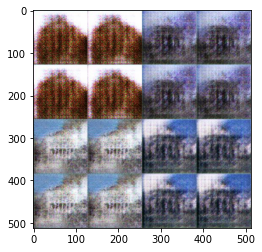

In [14]:
show_images = 8
# Plot the generated images
data_images = helper.get_batch(glob(os.path.join("./generated_images/", '*.jpg'))[:show_images], 64, 64, 'RGB')

plt.imshow(helper.images_square_grid(data_images, 'RGB'))

Here is a GIF that shows the how the images were generated in several training steps.

<img src="./imgs/architecture_result.gif" width="150">

## Conclusion

Hence, we have successfully generated architectural images using GANs. 

Despite the generated images aren’t of high-quality, these results prove that GANs can be quite helpful as a tool in the creative field. The following results were a result of training the model on a standard CPU for several hours. Upon training on a high-end GPU/TPU, the results can be expected to improve a lot.